In [1]:
library(tidyverse)
library(WGCNA)
library(cowplot)
library(matrixStats)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: dynamicTreeCut
Loading required package: fastcluster

Attaching package: ‘fastcluster’

The following object is masked from ‘package:stats’:

    hclust



Attaching package: ‘WGCNA’

The following object is masked from ‘package:stats’:

    cor


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘matrixStats’

The following object is masked 

In [2]:
options(stringsAsFactors = FALSE)
enableWGCNAThreads()

Allowing parallel execution with up to 15 working processes.


In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

event_code <- list("Alive" = 0, "Dead" = 1)

In [4]:
dset_idx <- 1

# Load data

In [5]:
lnames <- load(file = paste0(dirs$data_dir, "/saved_network_objects/", unified_dsets[dset_idx], "_tumor_data.RData"))
filtered_matrisome_df <- load_matrisome_df(matrisome_path) %>%
    dplyr::select(gene_symbol, division, category, gene_name, synonyms) %>%
    dplyr::filter(gene_symbol %in% colnames(data_expr))    # Only include genes in dataset


Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)


# Find soft thresholding power

In [6]:
sft <- pickSoftThreshold(data = data_expr, verbose = FALSE)

   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1      1   0.0404  0.256         0.9510 122.0000  1.20e+02 204.00
2      2   0.6320 -1.180         0.9680  27.5000  2.34e+01  84.90
3      3   0.9000 -1.540         0.9780   9.0700  5.95e+00  47.10
4      4   0.9230 -1.600         0.9490   3.8400  1.90e+00  30.20
5      5   0.9100 -1.580         0.9160   1.9400  6.98e-01  21.20
6      6   0.9280 -1.560         0.9410   1.1000  2.66e-01  15.60
7      7   0.9110 -1.500         0.9160   0.6780  1.09e-01  11.90
8      8   0.2660 -2.210         0.1070   0.4460  4.93e-02   9.34
9      9   0.9340 -1.430         0.9410   0.3080  2.30e-02   7.49
10    10   0.9220 -1.410         0.9170   0.2210  1.10e-02   6.12
11    12   0.9330 -1.360         0.9300   0.1250  2.41e-03   4.26
12    14   0.2260 -1.700         0.0101   0.0780  5.89e-04   3.10
13    16   0.2920 -1.860         0.1190   0.0524  1.54e-04   2.33
14    18   0.3220 -1.860         0.2170   0.0375  4.11e-05   2.00
15    20  

In [7]:
sft_df <- sft$fitIndices %>%
    as_tibble() %>%
    rename_with(function(c) { gsub("_$", "", tolower(gsub("\\.", "_", c))) }) %>%
    dplyr::mutate(scale_free_topology = -sign(slope) * sft_r_sq)
head(sft_df)

power,sft_r_sq,slope,truncated_r_sq,mean_k,median_k,max_k,scale_free_topology
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.04035199,0.2563108,0.9513925,121.594968,119.8822325,204.29356,-0.04035199
2,0.63223907,-1.1799013,0.9676561,27.515800,23.3537488,84.91982,0.63223907
3,0.90003187,-1.5418228,0.9777054,9.068202,5.9509679,47.14949,0.90003187
4,0.92293557,-1.6006232,0.9487568,3.844570,1.9029523,30.17543,0.92293557
5,0.90955062,-1.5818639,0.9163559,1.935289,0.6979871,21.16315,0.90955062
6,0.92754081,-1.5625528,0.9407358,1.097435,0.2664743,15.58920,0.92754081


## Visualize

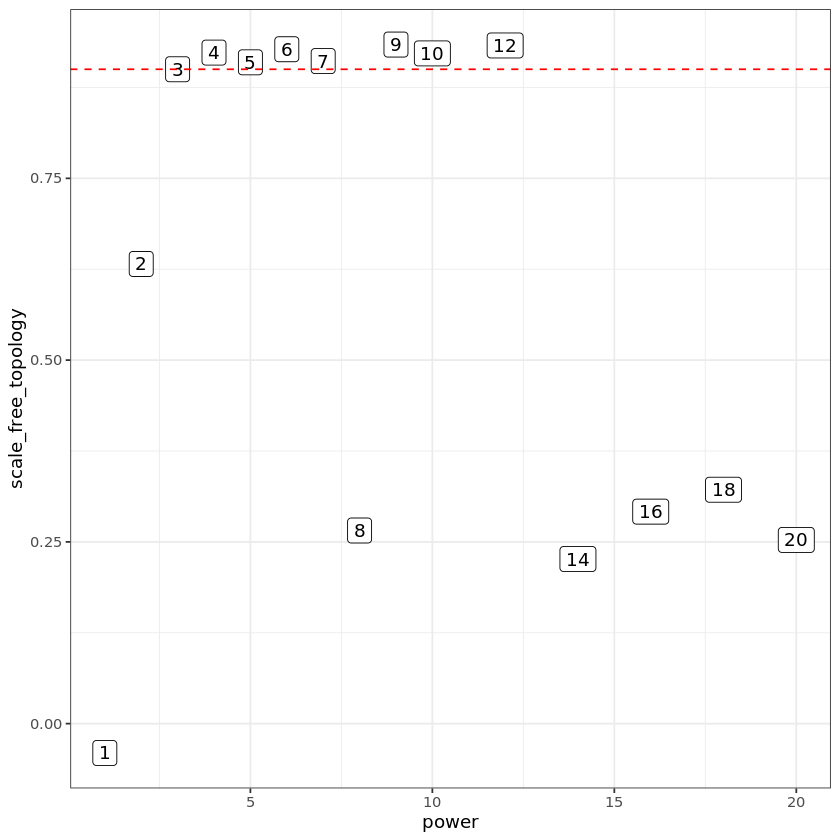

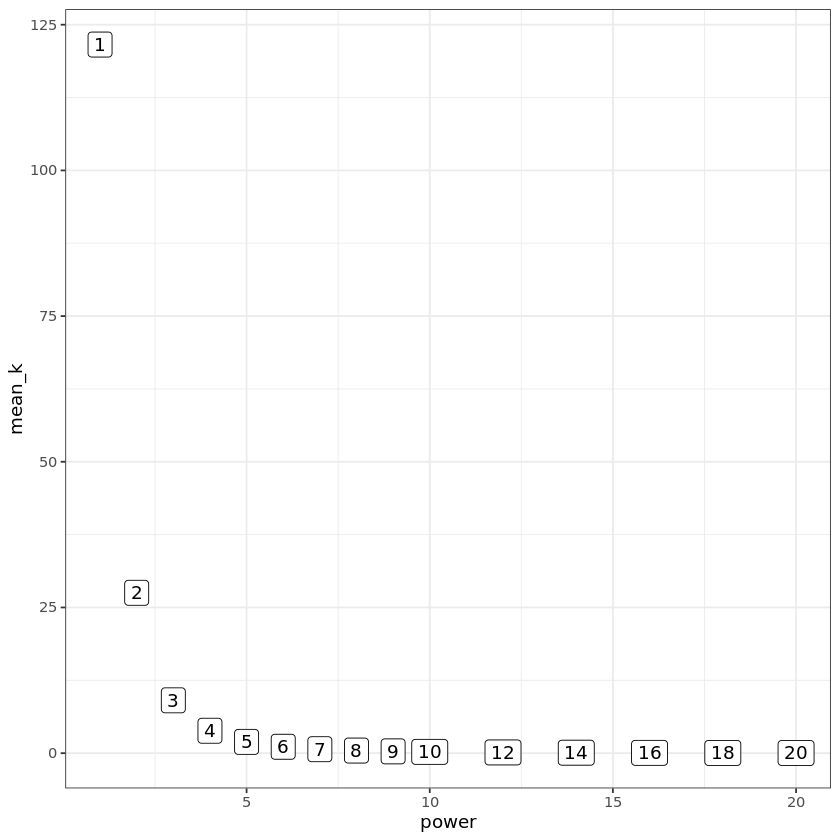

In [8]:
# sft_df
plt_1 <- ggplot(sft_df) +
    geom_label(aes(x = power, y = scale_free_topology, label = power)) +
    geom_hline(yintercept = 0.9, color = "red", linetype = "dashed") +
    theme_bw()
plt_2 <- ggplot(sft_df) +
    geom_label(aes(x = power, y = mean_k, label = power)) +
    theme_bw()
# plot_grid(plt_1, plt_2, labels = c("A", "B"), rows = 1, align="h")
plt_1
plt_2

In [9]:
# Pick first power which yields close to 0.9 scale free topology
thresh <- 0.9
tol <- 1e-2

soft_power <- sft_df %>%
    dplyr::filter(scale_free_topology > 0.9 | abs(scale_free_topology - thresh) < tol) %>%
    top_n(n = 1, wt = desc(power)) %>%
    dplyr::pull(power)

In [10]:
soft_power

[1] 3

# Adjacency

In [11]:
adj <- adjacency(data_expr, power = soft_power, corOptions = list(method = "pearson"), type = "unsigned")

# Topological Overlap Matrix (TOM)

In [12]:
tom <- TOMsimilarity(adj)
diss_tom <- 1 - tom

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


# Cluster on TOM

In [13]:
gene_tree <- hclust(as.dist(diss_tom), method = "average")

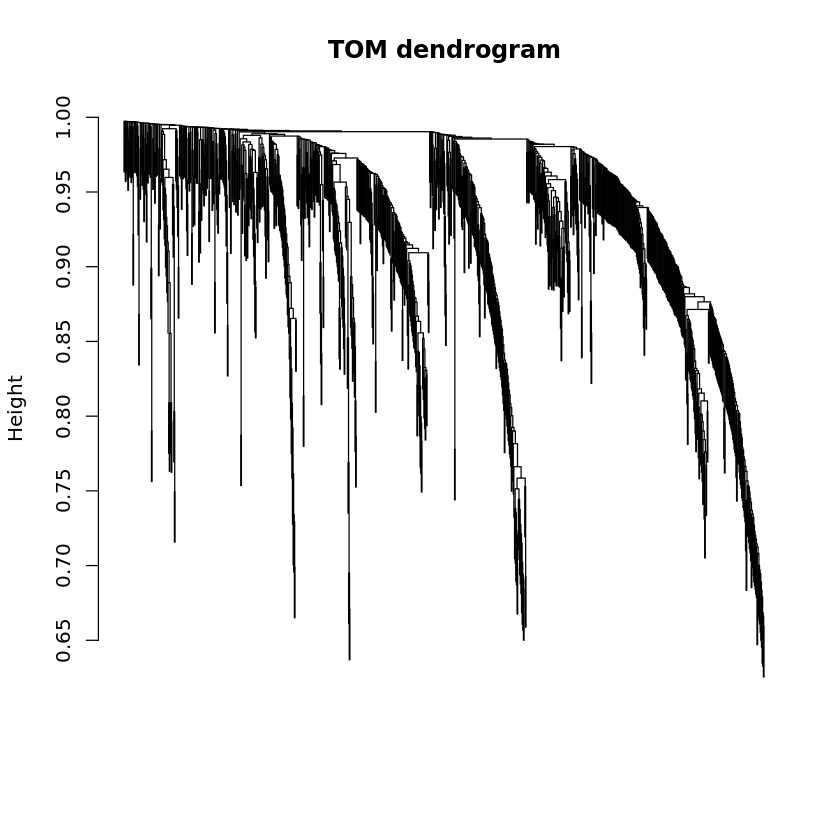

In [14]:
plot(gene_tree, labels = FALSE, xlab="", sub="", main = "TOM dendrogram")

In [15]:
# Set min. module size to 1/2 * min. matrisome category size
min_module_size <- filtered_matrisome_df %>%
    dplyr::group_by(category) %>%
    dplyr::summarize(n = n()) %>%
    top_n(n = 1, wt = desc(n)) %>%
    dplyr::pull(n) %>%
    (function(x) { round(x / 2) })

min_module_size

`summarise()` ungrouping output (override with `.groups` argument)


[1] 18

In [16]:
dynamic_mods <- cutreeDynamic(
    dendro = gene_tree, 
    distM = diss_tom, 
    deepSplit = 4, 
    pamRespectsDendro = FALSE, 
    minClusterSize = min_module_size
)
table(dynamic_mods)

 ..cutHeight not given, setting it to 0.995  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamic_mods
  0   1   2   3   4   5   6   7   8   9  10 
  7 303 179 141 126  69  47  43  33  28  28 

dynamic_colors
    black      blue     brown     green      grey   magenta      pink    purple 
       43       179       141        69         7        28        33        28 
      red turquoise    yellow 
       47       303       126 

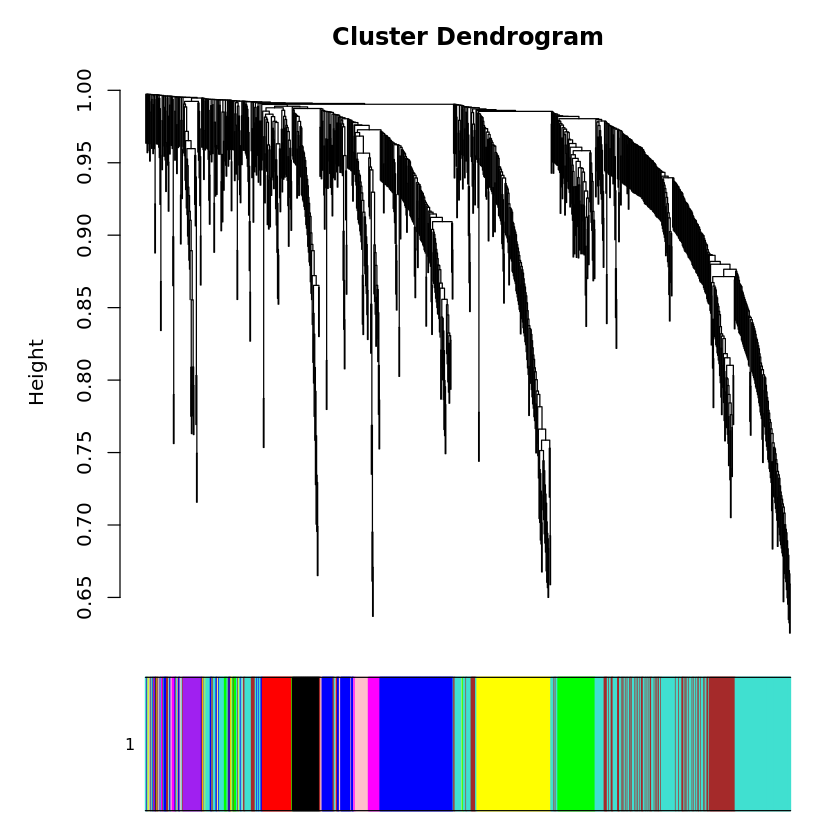

In [17]:
dynamic_colors <- labels2colors(dynamic_mods)
table(dynamic_colors)
plotDendroAndColors(gene_tree, dynamic_colors, dendroLabels = FALSE)

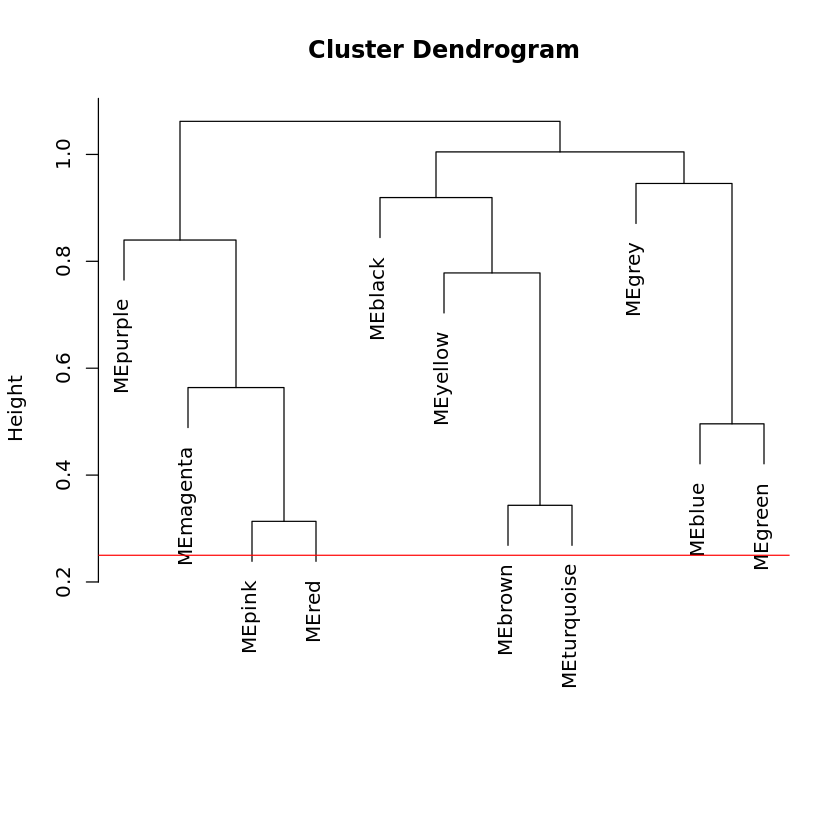

In [18]:
me_list <- moduleEigengenes(data_expr, colors = dynamic_colors)
mes <- me_list$eigengenes
me_diss <- 1 - WGCNA::cor(mes)
me_tree <- hclust(as.dist(me_diss), method = "average")
plot(me_tree, xlab = "", sub = "")

# Choose a correlation threshold
cor_thresh <- 0.75
me_diss_thresh <- 1 - cor_thresh
abline(h = me_diss_thresh, col = "red")

In [19]:
merged <- mergeCloseModules(data_expr, dynamic_colors, cutHeight = me_diss_thresh, verbose = 3)

 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.


In [20]:
merged_colors <- merged$colors
merged_mes <- merged$newMEs

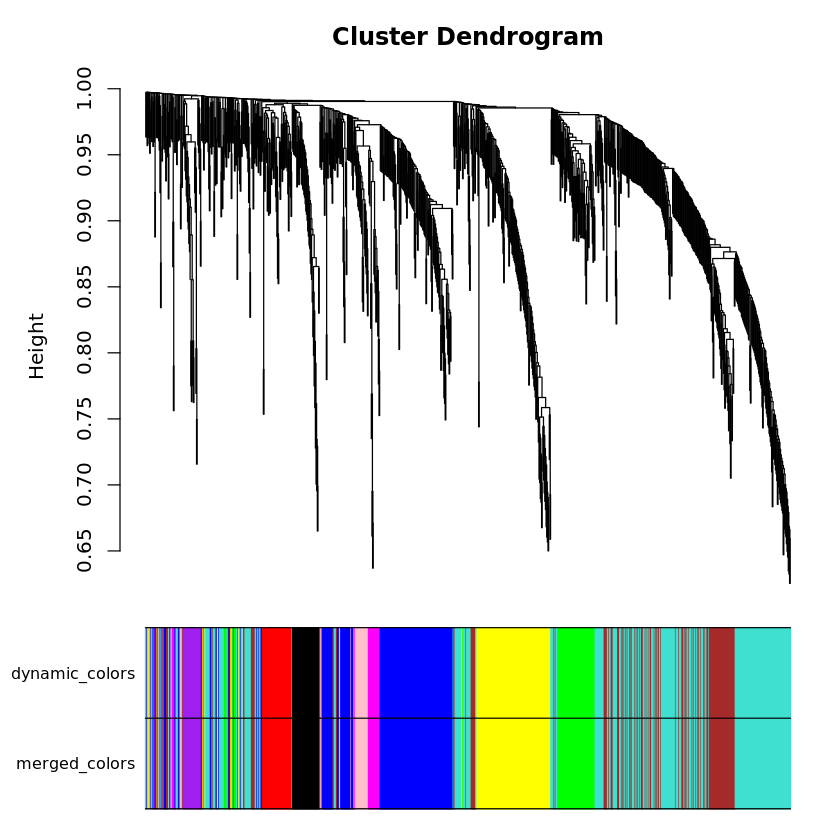

In [21]:
plotDendroAndColors(
    gene_tree, 
    cbind(dynamic_colors, merged_colors),
    dendroLabels = FALSE
)

In [22]:
module_colors <- merged_colors
color_order <- c("grey", standardColors())
module_labels <- match(module_colors, color_order) - 1
mes <- merged_mes

In [23]:
save(
    mes,
    module_labels,
    module_colors,
    gene_tree,
    file = paste0(dirs$data_dir, "/saved_network_objects/", unified_dsets[dset_idx], "_tumor_network.RData")
)